In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , TensorDataset
import matplotlib.pyplot as plt
#from lstm_net import LSTM

In [15]:
names = ['AC', 'AD', 'BC', 'BD']
types = ['train', 'val', 'test']
#load data
#mac: /Users/syunsei/Desktop/SII2025/process_data/classifier/
#win: C:\Github_LIU\SII2025\process_data\classifier\
for name in names:
    for type in types:
        locals()[name + '_' + type] = np.load('/Users/syunsei/Desktop/SII2025/process_data/classifier/' + name + '_' + type + '.npy')
        
X_train = np.concatenate((AC_train, AD_train, BC_train, BD_train), axis=0)
X_val = np.concatenate((AC_val, AD_val, BC_val, BD_val), axis=0)
X_test = np.concatenate((AC_test, AD_test, BC_test, BD_test), axis=0)
y_train = np.concatenate((np.zeros(AC_train.shape[0]), np.ones(AD_train.shape[0]), np.ones(BC_train.shape[0]) * 2, np.ones(BD_train.shape[0]) * 3), axis=0)
y_val = np.concatenate((np.zeros(AC_val.shape[0]), np.ones(AD_val.shape[0]), np.ones(BC_val.shape[0]) * 2, np.ones(BD_val.shape[0]) * 3), axis=0)
y_test = np.concatenate((np.zeros(AC_test.shape[0]), np.ones(AD_test.shape[0]), np.ones(BC_test.shape[0]) * 2, np.ones(BD_test.shape[0]) * 3), axis=0)

#split data into training and testing and validation
X_train=np.concatenate ((X_train[:,:,0:3],X_train[:,:,6:9]), axis=2)
X_val=np.concatenate ((X_val[:,:,0:3],X_val[:,:,6:9]), axis=2)
X_test=np.concatenate ((X_test[:,:,0:3],X_test[:,:,6:9]), axis=2)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
'''
#归一化
def min_max_normalize(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    range_val = max_val - min_val
    range_val[range_val == 0] = 1  # 防止除零错误
    return (data - min_val) / range_val
#X = min_max_normalize(X)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)
print(X.shape,X_train.shape, X_test.shape, X_val.shape,y_train.shape)
#draw X_train
plt.plot(X[1110])
plt.show()'''

batch_size = 50
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)


(715, 301, 6) (46, 301, 6) (47, 301, 6)
(715,) (46,) (47,)


In [16]:
#define hyperparameters
sequence_len = 301
input_len = 6
hidden_size = 128
num_layers = 2
num_classes = 4
num_epochs = 100
learning_rate = 0.01

In [17]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        cell_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (hidden_state, cell_state))
        out = self.output_layer(out[:, -1, :])
        return out

In [19]:
model = LSTM(input_len, hidden_size, num_layers, num_classes).to(device)
print(model)

LSTM(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=4, bias=True)
  (relu): ReLU()
)


In [20]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1; Batch 2/15]; Loss: 1.5494
Epoch [1; Batch 4/15]; Loss: 1.3677
Epoch [1; Batch 6/15]; Loss: 1.2880
Epoch [1; Batch 8/15]; Loss: 1.3559
Epoch [1; Batch 10/15]; Loss: 1.2106
Epoch [1; Batch 12/15]; Loss: 1.2288
Epoch [1; Batch 14/15]; Loss: 1.2785
Epoch [2; Batch 2/15]; Loss: 1.1846
Epoch [2; Batch 4/15]; Loss: 1.0522
Epoch [2; Batch 6/15]; Loss: 1.1736
Epoch [2; Batch 8/15]; Loss: 1.2493
Epoch [2; Batch 10/15]; Loss: 0.9798
Epoch [2; Batch 12/15]; Loss: 1.0015
Epoch [2; Batch 14/15]; Loss: 0.8828
Epoch [3; Batch 2/15]; Loss: 0.9120
Epoch [3; Batch 4/15]; Loss: 0.8298
Epoch [3; Batch 6/15]; Loss: 0.9150
Epoch [3; Batch 8/15]; Loss: 0.7074
Epoch [3; Batch 10/15]; Loss: 0.7472
Epoch [3; Batch 12/15]; Loss: 0.8139
Epoch [3; Batch 14/15]; Loss: 0.7947
Epoch [4; Batch 2/15]; Loss: 0.5937
Epoch [4; Batch 4/15]; Loss: 0.7938
Epoch [4; Batch 6/15]; Loss: 0.5265
Epoch [4; Batch 8/15]; Loss: 0.5612
Epoch [4; Batch 10/15]; Loss: 0.3802
Epoch [4; Batch 12/15]; Loss: 0.4046
Epoch [4; Batch 1

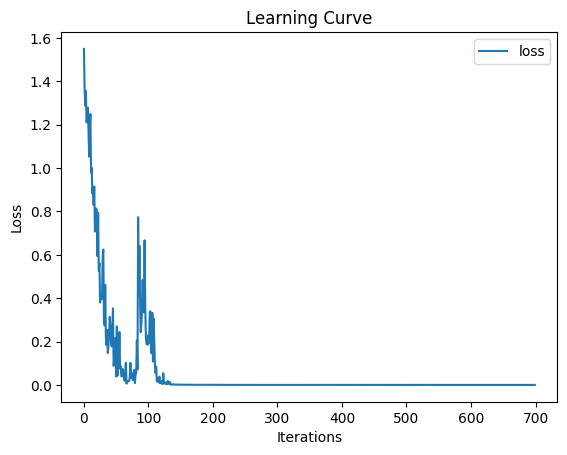

In [21]:
def train(num_epochs, model, train_loader, loss_function):
    total_step = len(train_loader)
    
    for epoch in range(num_epochs):
        for batch, (lifts, labels) in enumerate(train_loader):
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            loss = loss_function(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (batch+1) % 2 == 0:
                loss_list.append(loss.item())
                print(f"Epoch [{epoch+1}; Batch {batch+1}/{total_step}]; Loss: {loss.item():.4f}")
                
loss_list = []
#draw learning curve
def plot_learning_curve(loss_list):
    plt.plot(loss_list, label="loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()
    
train(num_epochs, model, train_loader, loss_function)
plot_learning_curve(loss_list)


In [22]:
def validate(model, val_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for lifts, labels in val_loader:
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f"Validation accuracy: {100 * correct / total}%")

validate(model, val_loader)

Validation accuracy: 34.78260869565217%


In [23]:
def test(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for lifts, labels in test_loader:
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f"Test accuracy: {100 * correct / total}%")

test(model, test_loader)

Test accuracy: 34.04255319148936%


In [24]:
#save model
torch.save(model.state_dict(), "model.pth")
